In [23]:
import argparse
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.utils import make_grid
import keras
from keras import datasets, layers, models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, get_scorer_names, precision_score, recall_score, f1_score
from sklearn import metrics
from PIL import Image, ImageDraw
from tqdm import tqdm
# We import the data set from tensorflow and build the model there
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

import torch
# If you do not have a GPU or do not want to run this code on your GPU, comment out the following lines
torch.cuda.empty_cache()
torch.cuda.is_available()

True

## Performing Hand Segmentation with a Pre-Trained Pytorch Model

The below code is taken from: https://github.com/guglielmocamporese/hands-segmentation-pytorch

In [2]:
def meanIoU(logits, labels):
    """
    Computes the mean intersection over union (mIoU).
    
    Args:
        logits: tensor of shape [bs, c, h, w].
        labels: tensor of shape [bs, h, w].
    
    Output:
        miou: scalar.
    """
    num_classes = logits.shape[1]
    preds = F.softmax(logits, 1)
    preds_oh = F.one_hot(preds.argmax(1), num_classes).permute(0, 3, 1, 2).to(torch.float32) # [bs, c, h, w] 
    labels_oh = F.one_hot(labels, num_classes).permute(0, 3, 1, 2).to(torch.float32) # [bs, c, h, w]
    tps = (preds_oh * labels_oh).sum(-1).sum(-1) # true positives [bs, c]
    fps = (preds_oh * (1 - labels_oh)).sum(-1).sum(-1) # false positives [bs, c]
    fns = ((1 - preds_oh) * labels_oh).sum(-1).sum(-1) # false negatives [bs, c]
    iou = tps / (tps + fps + fns + 1e-8) # [bs, c]
    return iou.mean(-1).mean(0)

In [3]:
def show_sample(image, mask=None, alpha=0.7):
    print('Image shape:', image.shape)
    plt.imshow(image.permute(1, 2, 0))
    if mask is not None:
        print('Mask shape:', mask.shape)

        plt.imshow(mask[0], alpha=alpha)
    plt.show()


def show_samples(images, masks=None, alpha=0.7, nrow=4):
    print('Images shape:', images.shape)
    if masks is not None:
        print('Masks shape:', masks.shape)
        B, C, H, W = images.shape
        col = [0.2, 0.3, 0.8]
        col = torch.tensor(col).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).repeat(B, 1, H, W)
        images = torch.where(masks.repeat(1, 3, 1, 1) > 0,
                             alpha * col + (1 - alpha) * images, images)
    image_grid = make_grid(images, nrow=nrow, padding=0)
    plt.figure(figsize=(15, 15))
    plt.imshow(image_grid.permute(1, 2, 0), aspect='auto')
    plt.axis(False)
    plt.show()

In [4]:
class Denorm(object):
    def __init__(self, mean=None, std=None):
        self.mean = np.array([0.0, 0.0, 0.0]) if mean is None else mean
        self.std = np.array([1.0, 1.0, 1.0]) if std is None else std

    def __call__(self, x):
        """
        Denormalize the image.

        Args:
            x: tensor of shape [bs, c, h, w].

        Output:
            x_denorm: tensor of shape [bs, c, h, w].
        """
        denorm_fn = transforms.Normalize(mean=- self.mean / (self.std + 1e-8), std=1.0 / (self.std + 1e-8))
        x_denorm = []
        for x_i in x:
            x_denorm += [denorm_fn(x_i)]
        x_denorm = torch.stack(x_denorm, 0)
        return x_denorm

In [5]:
def get_dataloader(data_base_path, partition, datasets, image_transform=None,
                   mask_transform=None, batch_size=32, num_workers=0, pin_memory=True, shuffle=False):
    """
    Get the dataloader.

    Args:
        data_base_path: string where the data are stored.
        partition: string in ['train', 'validation', 'test'].
        datasets: list of strings for selecting the sounrce of the data.
        image_transforms: transform applied to the image.
        mask_transform: transform applied to the mask.
        batch_size: integer that specifies the batch size.
        num_workers: the number of workers.
        pin_memory: boolean.

    Output:
        dl: the dataloader (PyTorch DataLoader).
    """
    ds_list = []

    if 'eyth' in datasets:
        tranform = transforms.ToTensor()
        ds_eyth = EYTHDataset(
            data_base_path=os.path.join(data_base_path, 'eyth_dataset'),
            partition=partition,
            image_transform=tranform if image_transform is None else image_transform,
            mask_transform=tranform if mask_transform is None else mask_transform,
        )
        ds_list += [ds_eyth]

    if 'eh' in datasets:
        tranform = transforms.ToTensor()
        ds_eh = EgoHandsDataset(
            data_base_path=os.path.join(data_base_path, 'egohands_data'),
            partition=partition,
            image_transform=tranform if image_transform is None else image_transform,
            mask_transform=tranform if mask_transform is None else mask_transform,
        )
        ds_list += [ds_eh]

    if 'hof' in datasets:
        tranform = transforms.ToTensor()
        ds_hof = HOFDataset(
            data_base_path=os.path.join(data_base_path, 'hand_over_face'),
            partition=partition,
            image_transform=tranform if image_transform is None else image_transform,
            mask_transform=tranform if mask_transform is None else mask_transform,
        )
        ds_list += [ds_hof]

    if 'gtea' in datasets:
        tranform = transforms.Compose([
            transforms.Resize((405, 720)),
            transforms.ToTensor(),
        ])
        ds_gtea = GTEADataset(
            data_base_path=os.path.join(data_base_path, 'hand2K_dataset'),
            partition=partition,
            image_transform=tranform if image_transform is None else image_transform,
            mask_transform=tranform if mask_transform is None else mask_transform,
        )
        ds_list += [ds_gtea]

    # Concatenate datasets
    ds_cat = ConcatDataset(ds_list)
    dl = DataLoader(ds_cat, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers, shuffle=shuffle)
    return dl

In [6]:
def hand_segmentor(pretrained=True, *args, **kwargs):
    """
    Hand segmentor based on a DeepLabV3 model with a ResNet50 encoder.
    DeeplabV3: https://arxiv.org/abs/1706.05587
    ResNet50: https://arxiv.org/abs/1512.03385
    """
    model = HandSegModel(*args, **kwargs)
    if pretrained:
        #os.system('chmod +x ./scripts/download_model_checkpoint.sh')
        #os.system('./scripts/download_model_checkpoint.sh')
        _download_file_from_google_drive('1w7dztGAsPHD_fl_Kv_a8qHL4eW92rlQg', './checkpoint/checkpoint.ckpt')
        model = model.load_from_checkpoint('./checkpoint/checkpoint.ckpt', *args, **kwargs)
    return model


def _download_file_from_google_drive(id, destination):

    url = f'https://drive.google.com/uc?id={id}'
    path = os.path.dirname(destination)
    if not os.path.exists(path):
        os.makedirs(path)
    gdown.download(url, destination, quiet=False)

dependencies = ['torch', 'pytorch_lightning']

In [7]:
class HandSegModel(pl.LightningModule):
    """
    This model is based on the PyTorch DeepLab model for semantic segmentation.
    """
    def __init__(self, pretrained=False, lr=1e-4, in_channels=3):
        super().__init__()
        assert in_channels in [1, 3, 4]
        self.deeplab = self._get_deeplab(pretrained=pretrained, num_classes=2, in_channels=in_channels)
        self.denorm_image_for_tb_log = None # For tensorboard logging
        self.lr = lr
        if pretrained:
            if in_channels == 1:
                mean, std = np.array([0.5]), np.array([0.5]) 
            elif in_channels == 3:
                mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225]) 
            elif in_channels == 4:
                mean, std = np.array([0.485, 0.456, 0.406, 0.5]), np.array([0.229, 0.224, 0.225, 0.5]) 
            self.denorm_image_for_tb_log = Denorm(mean, std)

    def _get_deeplab(self, pretrained=False, num_classes=2, in_channels=3):
        """
        Get the PyTorch DeepLab model architecture.
        """
        deeplab = torchvision.models.segmentation.deeplabv3_resnet50(
            pretrained=False,
            num_classes=num_classes
        )
        if pretrained:
            deeplab_21 = torchvision.models.segmentation.deeplabv3_resnet50(
                pretrained=True,
                progress=True,
                num_classes=21
            )
            for c1, c2 in zip(deeplab.children(), deeplab_21.children()):
                for p1, p2 in zip(c1.parameters(), c2.parameters()):
                    if p1.shape == p2.shape:
                        p1.data = p2.data
        if in_channels == 1:
            weight = deeplab.backbone.conv1.weight
            deeplab.backbone.conv1.weight = nn.Parameter(weight.data[:, 0:1])
        elif in_channels == 4:
            weight = deeplab.backbone.conv1.weight
            C, _, H, W = weight.shape
            deeplab.backbone.conv1.weight = nn.Parameter(torch.cat([
                weight.data,
                torch.randn(C, 1, H, W, device=weight.device) * 0.1,
            ], 1))
        return deeplab

    def forward(self, x):
        return self.deeplab(x)['out']

    def training_step(self, batch, idx_batch):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.softmax(logits, 1).detach()
        miou = meanIoU(y_hat, y.argmax(1))

        # Cache
        self.log('train_bce', loss, prog_bar=True)
        self.log('train_mIoU', miou, prog_bar=True)
        return loss

    def validation_step(self, batch, idx_batch):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.softmax(logits, 1).detach()
        miou = meanIoU(y_hat, y.argmax(1))

        # Cache
        self.log('validation_bce', loss, prog_bar=True)
        self.log('validation_mIoU', miou, prog_bar=True)
        if idx_batch == 0:
            tb_log = self.trainer.logger.experiment
            if self.denorm_image_for_tb_log:
                x = self.denorm_image_for_tb_log(x)
            x_grid = make_grid(x[:16], nrow=4)
            y_hat_grid = make_grid(y_hat[:16].argmax(1).unsqueeze(1), nrow=4)[0:1]
            tb_log.add_image('validation_images', x_grid.cpu().numpy())
            tb_log.add_image('validation_preds', y_hat_grid.cpu().numpy())
        return loss

    def test_step(self, batch, idx_batch):
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.softmax(logits, 1).detach()
        miou = meanIoU(y_hat, y.argmax(1))

        # Cache
        self.log('test_bce', loss, prog_bar=True)
        self.log('test_mIoU', miou, prog_bar=True)
        if idx_batch == 0:
            tb_log = self.trainer.logger.experiment
            if self.denorm_image_for_tb_log:
                x = self.denorm_image_for_tb_log(x)
            x_grid = make_grid(x[:16], nrow=4)
            y_hat_grid = make_grid(y_hat[:16].argmax(1).unsqueeze(1), nrow=4)[0:1]
            tb_log.add_image('test_images', x_grid.cpu().numpy())
            tb_log.add_image('test_preds', y_hat_grid.cpu().numpy())
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    def set_denorm_fn(self, denorm_fn):
        self.denorm_image_for_tb_log = denorm_fn

In [8]:
def get_args(folder):
    """
    read the input arguments.
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--mode',  type=str, default='predict',
                        help='Mode of the program. Can be "train", "test" or "predict".')
    parser.add_argument('--epochs', type=int, default=50, help='The number of epochs used for the training.')
    parser.add_argument('--batch_size', type=int, default=16, help='The batch size.')
    parser.add_argument('--gpus', type=int, default=1, help='The number of gpus used.')
    parser.add_argument('--datasets', type=str, default='eyth eh hof gtea', help='List of datasets to use.')
    parser.add_argument('--height', type=int, default=256, help='The height of the input image.')
    parser.add_argument('--width', type=int, default=256, help='THe width of the input image.')
    parser.add_argument('--data_base_path', type=str, default=folder, help='The path of the input dataset.')
    parser.add_argument('--model_pretrained', default=True, action='store_true',
                        help='Load the PyTorch pretrained model.')
    parser.add_argument('--model_checkpoint', type=str, default="Distracted Driver Dataset\checkpoint\checkpoint.ckpt", help='The model checkpoint to load.')
    parser.add_argument('--lr', type=float, default=3e-4, help='The learning rate.')
    parser.add_argument('--in_channels', type=int, default=3, choices=[1, 3, 4],
                        help='The number of input channels (3 for RGB, 1 for Grayscale, 4 for RGBD).')
    args, unknown = parser.parse_known_args()
    print(json.dumps(vars(args), indent=4))
    return args


def get_model(args):
    """
    build the model.
    """
    model_args = {
        'pretrained': args.model_pretrained,
        'lr': args.lr,
        'in_channels': args.in_channels,
    }
    model = HandSegModel(**model_args)
    if len(args.model_checkpoint) > 0:
        model = model.load_from_checkpoint(args.model_checkpoint, **model_args)
        print(f'Loaded checkpoint from {args.model_checkpoint}.')
    return model


def get_image_transform(args):
    """
    build the image transforms.
    """
    image_transform = None
    pad_rgb2rgbd = lambda x: torch.cat([x, torch.zeros(3, x.shape[1], x.shape[2])], 0)
    pad_gray2rgbd = lambda x: torch.cat([x.repeat(3, 1, 1), torch.zeros(3, x.shape[1], x.shape[2])], 0)
    def to_rgbd(x):
        C = x.shape[0]
        if C == 4: return x
        elif C == 3: return pad_rgb2rgbd(x)
        elif C == 1: return pad_gray2rgbd(x)
    if args.in_channels == 1:
        image_transform = transforms.Compose([
            transforms.Resize((args.height, args.width)),
            transforms.ToTensor(),
            lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1),
            lambda x: x.mean(0, keepdims=True), # convert RGB into grayscale
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
    elif args.in_channels == 3:
        image_transform = transforms.Compose([
            transforms.Resize((args.height, args.width)),
            transforms.ToTensor(),
            lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif args.in_channels == 4:
        image_transform = transforms.Compose([
            transforms.Resize((args.height, args.width)),
            transforms.ToTensor(),
            lambda x: x if x.shape[0] == 4 else to_rgbd(x),
            transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5]),
        ])
    return image_transform


def get_dataloaders(args):
    """
    build the dataloaders.
    """
    image_transform = get_image_transform(args)
    mask_transform = transforms.Compose([
        transforms.Resize((args.height, args.width)),
        transforms.ToTensor(),
        lambda m: torch.where(m > 0, torch.ones_like(m), torch.zeros_like(m)),
        lambda m: F.one_hot(m[0].to(torch.int64), 2).permute(2, 0, 1).to(torch.float32),
    ])
    dl_args = {
        'data_base_path': args.data_base_path,
        'datasets': args.datasets.split(' '),
        'image_transform': image_transform,
        'mask_transform': mask_transform,
        'batch_size': args.batch_size,
    }
    dl_train = get_dataloader(**dl_args, partition='train', shuffle=True)
    dl_validation = get_dataloader(**dl_args, partition='validation', shuffle=False)
    dl_test = get_dataloader(**dl_args, partition='test', shuffle=False)
    dls = {
        'train': dl_train,
        'validation': dl_validation,
        'test': dl_test,
    }
    return dls


def get_predict_dataset(args):
    """
    """
    image_paths = sorted(os.listdir(args.data_base_path))
    image_paths = [os.path.join(args.data_base_path, f) for f in image_paths]
    print(f'Found {len(image_paths)} in {args.data_base_path}.')
    transform = get_image_transform(args)

    class ImageDataset(Dataset):
        def __init__(self, image_paths, transform=None):
            super(ImageDataset, self).__init__()
            self.image_paths = image_paths
            self.transform = transform

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image_path = self.image_paths[idx]
            image = Image.open(image_path)
            if self.transform is not None:
                image = self.transform(image)
            return image, image_path
    return ImageDataset(image_paths, transform=transform)

def main(args):
    """
    main function.
    """

    # Model
    model = get_model(args)
    print("model built")

    # Mode
    if args.mode == 'train':
        dls = get_dataloaders(args) # Dataloader
        trainer = pl.Trainer(max_epochs=args.epochs, gpus=args.gpus)
        trainer.fit(model, dls['train'], dls['validation'])
    elif args.mode == 'validation':
        dls = get_dataloaders(args) # Dataloader
        trainer = pl.Trainer(gpus=args.gpus)
        trainer.test(model, dls['validation'])
    elif args.mode == 'test':
        dls = get_dataloaders(args) # Dataloader
        trainer = pl.Trainer(gpus=args.gpus)
        trainer.test(model, dls['test'])
    elif args.mode == 'predict':
        ds = get_predict_dataset(args) # Dataset

        # Save prediction
        _ = model.eval()
        device = next(model.parameters()).device
        for x, x_path in tqdm(ds, desc='Save predictions'):
            H, W = x.shape[-2:]
            x = transforms.Resize((256, 256))(x)
            x = x.unsqueeze(0).to(device)
            logits = model(x).detach().cpu()
            preds = F.softmax(logits, 1).argmax(1)[0] * 255 # [h, w]
            preds = Image.fromarray(preds.numpy().astype(np.uint8), 'L')
            preds = preds.resize((W, H))
            preds.save(os.path.join(os.getcwd(), destinationfolder_path, trainortest(x_path), findclass(x_path),naming(x_path)+".png"))
    else:
        raise Exception(f'Error. Mode "{args.mode}" is not supported.')

We use the above code taken from: https://github.com/guglielmocamporese/hands-segmentation-pytorch and run the model on our images to extract out the hands.

In [9]:
def trainortest(filepath):
    return filepath.split("\\")[-3]


def findclass(filepath):
    return filepath.split("\\")[-2]


def naming(filepath):
    return filepath.split("\\")[-1]

In [4]:
CLASS = [["c0", "Safe Driving"], ["c1", "Text"], ["c2", "Phone"],
           ["c3", "Adjusting Radio"], ["c4", "Drinking"],
           ["c5", "Reaching Behind"], ["c6", "Hair or Makeup"],
           ["c7", "Talking to Passenger"]]

datafolder = "Combined New"  # Initial dataset folder
datafolder_path = os.path.join(os.getcwd(), datafolder)
destinationfolder = "Prediction New"  # Prediction of hand segmentation
destinationfolder_path = os.path.join(os.getcwd(), "Data", destinationfolder)
finalfolder = "Extracted New"
finalfolder_path = os.path.join(os.getcwd(), "Data", finalfolder)

if not os.path.exists(destinationfolder_path):
    os.mkdir(destinationfolder_path)
if not os.path.exists(os.path.join(os.getcwd(), destinationfolder_path, "test")):
    os.mkdir(os.path.join(os.getcwd(), destinationfolder_path, "test"))
for cls in CLASS:
    if not os.path.exists(os.path.join(os.getcwd(), destinationfolder_path, "test", cls[0])):
        os.mkdir(os.path.join(os.getcwd(), destinationfolder_path, "test", cls[0]))
if not os.path.exists(os.path.join(os.getcwd(), destinationfolder_path, "train")):
    os.mkdir(os.path.join(os.getcwd(), destinationfolder_path, "train"))
for cls in CLASS:
    if not os.path.exists(os.path.join(os.getcwd(), destinationfolder_path, "train", cls[0])):
        os.mkdir(os.path.join(os.getcwd(), destinationfolder_path, "train", cls[0]))

TEST_CLS = [os.path.join(os.getcwd(), datafolder_path, "test", cls[0]) for cls in CLASS]
TRAIN_CLS = [os.path.join(os.getcwd(), datafolder_path, "train", cls[0]) for cls in CLASS]


In [11]:
if __name__ == '__main__':
    for path in TEST_CLS:
        print(path)
        print(len(os.listdir(path)))
        args = get_args(path)
        main(args)
    for path in TRAIN_CLS:
        print(path)
        print(len(os.listdir(path)))
        args = get_args(path)
        main(args)

C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c0
711
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\test\\c0",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


C:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\ASUS\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ASUS\anaconda3\lib\site-packages\pytorch_li

Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 711 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c0.


Save predictions:   0%|                                                                        | 0/711 [00:00<?, ?it/s]C:\Users\ASUS\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Save predictions: 100%|██████████████████████████████████████████████████████████████| 711/711 [04:56<00:00,  2.40it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c1
667
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\test\\c1",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 667 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c1.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 667/667 [04:31<00:00,  2.46it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c2
602
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\test\\c2",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 602 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c2.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 602/602 [04:00<00:00,  2.51it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c3
264
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\test\\c3",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 264 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c3.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 264/264 [01:45<00:00,  2.51it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c4
255
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\test\\c4",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 255 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c4.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 255/255 [01:40<00:00,  2.53it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c5
243
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\test\\c5",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 243 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c5.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 243/243 [01:36<00:00,  2.51it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c6
242
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\test\\c6",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 242 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c6.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 242/242 [01:36<00:00,  2.52it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c7
430
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\test\\c7",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 430 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\test\c7.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 430/430 [02:51<00:00,  2.51it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c0
2131
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\train\\c0",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 2131 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c0.


Save predictions: 100%|████████████████████████████████████████████████████████████| 2131/2131 [14:08<00:00,  2.51it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c1
2000
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\train\\c1",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 2000 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c1.


Save predictions: 100%|████████████████████████████████████████████████████████████| 2000/2000 [13:16<00:00,  2.51it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c2
1805
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\train\\c2",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 1805 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c2.


Save predictions: 100%|████████████████████████████████████████████████████████████| 1805/1805 [11:53<00:00,  2.53it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c3
791
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\train\\c3",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 791 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c3.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 791/791 [05:12<00:00,  2.53it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c4
762
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\train\\c4",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 762 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c4.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 762/762 [05:03<00:00,  2.51it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c5
726
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\train\\c5",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 726 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c5.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 726/726 [04:49<00:00,  2.51it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c6
723
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\train\\c6",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 723 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c6.


Save predictions: 100%|██████████████████████████████████████████████████████████████| 723/723 [04:47<00:00,  2.52it/s]


C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c7
1287
{
    "mode": "predict",
    "epochs": 50,
    "batch_size": 16,
    "gpus": 1,
    "datasets": "eyth eh hof gtea",
    "height": 256,
    "width": 256,
    "data_base_path": "C:\\Users\\ASUS\\Desktop\\Distracted Driver Dataset\\Combined New\\train\\c7",
    "model_pretrained": true,
    "model_checkpoint": "Distracted Driver Dataset\\checkpoint\\checkpoint.ckpt",
    "lr": 0.0003,
    "in_channels": 3
}


Lightning automatically upgraded your loaded checkpoint from v1.2.2 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\ASUS\Desktop\Distracted Driver Dataset\checkpoint\checkpoint.ckpt`


Loaded checkpoint from Distracted Driver Dataset\checkpoint\checkpoint.ckpt.
model built
Found 1287 in C:\Users\ASUS\Desktop\Distracted Driver Dataset\Combined New\train\c7.


Save predictions: 100%|████████████████████████████████████████████████████████████| 1287/1287 [08:36<00:00,  2.49it/s]


In [12]:
t = ["test", "train"]
if not os.path.exists(finalfolder_path):
    os.mkdir(finalfolder_path)
for x in t:
    if not os.path.exists(os.path.join(os.getcwd(), finalfolder_path, x)):
        os.mkdir(os.path.join(os.getcwd(), finalfolder_path, x))
    for cls in CLASS:
        if not os.path.exists(os.path.join(os.getcwd(), finalfolder_path, x, cls[0])):
            os.mkdir(os.path.join(os.getcwd(), finalfolder_path, x, cls[0]))

We use the hand masks as predicted by the model and extract out the relevant pixels from the original image to get our final hands dataset.

In [13]:
for cls in TEST_CLS:
    for ori_name in os.listdir(cls):  # Put on the hand segmented image as a mask on the original test image
        ori_img = cv2.imread(os.path.join(os.getcwd(), cls, ori_name))
        mask = cv2.imread(os.path.join(os.getcwd(), destinationfolder_path, "test", naming(cls), ori_name + ".png"))
        W, H, C = ori_img.shape
        mask = cv2.resize(mask, (H, W))
        mask[mask < 128] = 1
        mask[mask > 128] = 0
        ori_img = ori_img * (mask == 0)
        ori_img[mask == 1] = 255
        cv2.imwrite(os.path.join(os.getcwd(), finalfolder_path, "test", naming(cls), ori_name + ".png"), ori_img)

for cls in TRAIN_CLS:
    for ori_name in os.listdir(cls):  # Put on the hand segmented image as a mask on the original train image
        ori_img = cv2.imread(os.path.join(os.getcwd(), cls, ori_name))
        mask = cv2.imread(os.path.join(os.getcwd(), destinationfolder_path, "train", naming(cls), ori_name + ".png"))
        W, H, C = ori_img.shape
        mask = cv2.resize(mask, (H, W))
        mask[mask < 128] = 1
        mask[mask > 128] = 0
        ori_img = ori_img * (mask == 0)
        ori_img[mask == 1] = 255
        cv2.imwrite(os.path.join(os.getcwd(), finalfolder_path, "train", naming(cls), ori_name + ".png"),
                    ori_img)

In [8]:
X_train = []
X_test = []
Y_train = []
Y_test = []
t = ["test", "train"]
X = [X_test, X_train]
Y = [Y_test, Y_train]

for i in range(2):
    for cls in os.listdir(os.path.join(os.getcwd(), finalfolder_path, t[i])):
        for ori_name in os.listdir(os.path.join(os.getcwd(), finalfolder_path, t[i], cls)):
            X[i].append(os.path.join(os.getcwd(), finalfolder_path, t[i], cls, ori_name))
            Y[i].append(int(cls[1]))

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print(X_train.shape, X_test.shape,Y_train.shape, Y_test.shape)

(10225,) (3414,) (10225,) (3414,)


In [10]:
(X_train_final, X_val, Y_train_final, Y_val) = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=42)
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)
X_train_final = np.asarray(X_train_final)
Y_traim_final = np.asarray(Y_train_final)
print(X_val.shape)
print(Y_val.shape)

(2045,)
(2045,)


In [11]:
X_train_resized = []
Y_train_resized = []
i = 0
for x in X_train_final:
    if len(x)!=0 and len(x[0])!=0:
        img = cv2.imread(x)
        img = cv2.resize(img, (75, 100))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # img_blur = cv2.GaussianBlur(img, (3,3), 0)
        # edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
        # edges = np.asarray(edges)
        # edges = edges.reshape(120, 80, 1)
        X_train_resized.append(img/255.0)
        Y_train_resized.append(Y_train_final[i])
    i+=1
X_train_resized = np.asarray(X_train_resized)
X_train_resized = X_train_resized.reshape(-1, 100, 75, 1)
print("X_train_resized shape: ", X_train_resized.shape)

X_train_resized shape:  (8180, 100, 75, 1)


Text(0, 0.5, 'Frequency')

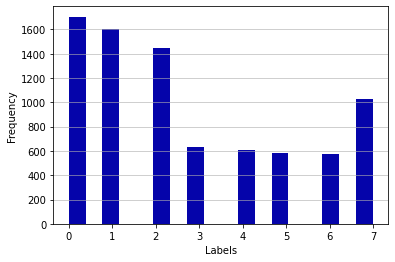

In [12]:
n, bins, patches = plt.hist(x=Y_train_resized, bins='auto', color='#0504aa')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Labels')
plt.ylabel('Frequency')

In [13]:
Y_train_resized = np_utils.to_categorical(Y_train_resized, 8)
print('New y_train shape: ', Y_train_resized.shape)

New y_train shape:  (8180, 8)


In [14]:
X_val_resized = []
Y_val_resized = []
i = 0
for x in X_val:
    if len(x)!=0 and len(x[0])!=0:
        img = cv2.imread(x)
        img = cv2.resize(img, (75, 100))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # img_blur = cv2.GaussianBlur(img, (3,3), 0)
        # edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
        # edges = np.asarray(edges)
        # edges = edges.reshape(120, 80, 1)
        X_val_resized.append(img/255)
        Y_val_resized.append(Y_val[i])
    i+=1
X_val_resized = np.asarray(X_val_resized)
X_val_resized = X_val_resized.reshape(-1, 100, 75, 1)
print(X_val_resized.shape)

(2045, 100, 75, 1)


In [15]:
Y_val_resized = np_utils.to_categorical(Y_val_resized, 8)
print('New y_train shape: ', Y_val_resized.shape)

New y_train shape:  (2045, 8)


In [16]:
model = models.Sequential()
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(100, 75, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 74, 16)        80        
                                                                 
 batch_normalization (BatchN  (None, 99, 74, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 23, 32)        2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 23, 32)       128       
 hNormalization)                                                 
                                                        

In [17]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = keras.optimizers.SGD(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 50
EPOCHS = 30

history = model.fit(X_train_resized, Y_train_resized, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=callbacks_list,
                    validation_data=(X_val_resized, Y_val_resized), shuffle = True)

Epoch 1/30
164/164 [==============================] - 10s 31ms/step - loss: 3.8391 - accuracy: 0.3028 - val_loss: 1.9385 - val_accuracy: 0.2303
Epoch 2/30
164/164 [==============================] - 4s 27ms/step - loss: 2.3351 - accuracy: 0.3829 - val_loss: 1.7108 - val_accuracy: 0.4200
Epoch 3/30
164/164 [==============================] - 5s 28ms/step - loss: 1.9140 - accuracy: 0.4237 - val_loss: 1.5467 - val_accuracy: 0.4284
Epoch 4/30
164/164 [==============================] - 5s 29ms/step - loss: 1.7034 - accuracy: 0.4493 - val_loss: 1.5091 - val_accuracy: 0.4323
Epoch 5/30
164/164 [==============================] - 4s 27ms/step - loss: 1.5521 - accuracy: 0.4704 - val_loss: 1.9563 - val_accuracy: 0.3584
Epoch 6/30
164/164 [==============================] - 4s 27ms/step - loss: 1.4578 - accuracy: 0.4936 - val_loss: 1.5874 - val_accuracy: 0.4240
Epoch 7/30
164/164 [==============================] - 4s 27ms/step - loss: 1.3838 - accuracy: 0.5149 - val_loss: 1.4760 - val_accuracy: 0.455

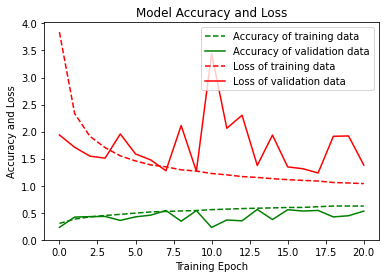

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [19]:
X_test_resized = []
Y_test_resized = []
i = 0
for x in X_test:
    if len(x)!=0 and len(x[0])!=0:
        img = cv2.imread(x)
        img = cv2.resize(img, (75, 100))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        X_test_resized.append(img/255)
        Y_test_resized.append(Y_test[i])
    i+=1
X_test_resized = np.asarray(X_test_resized)
X_test_resized = X_test_resized.reshape(-1, 100, 75, 1)
print(X_test_resized.shape)

(3414, 100, 75, 1)


In [20]:
Y_test_resized = np_utils.to_categorical(Y_test_resized, 8)
print('New y_train shape: ', Y_test_resized.shape)

New y_train shape:  (3414, 8)


In [21]:
score = model.evaluate(X_test_resized, Y_test_resized, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

107/107 [==============================] - 1s 9ms/step - loss: 1.3669 - accuracy: 0.5363

Accuracy on test data: 0.54

Loss on test data: 1.37


107/107 [==============================] - 1s 6ms/step


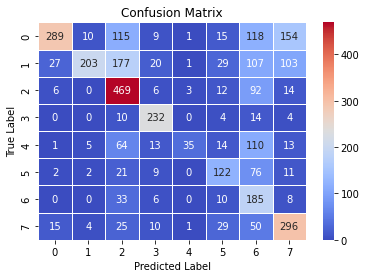


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.85      0.41      0.55       711
           1       0.91      0.30      0.46       667
           2       0.51      0.78      0.62       602
           3       0.76      0.88      0.82       264
           4       0.85      0.14      0.24       255
           5       0.52      0.50      0.51       243
           6       0.25      0.76      0.37       242
           7       0.49      0.69      0.57       430

    accuracy                           0.54      3414
   macro avg       0.64      0.56      0.52      3414
weighted avg       0.68      0.54      0.53      3414



In [22]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

y_pred_test = model.predict(X_test_resized)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test_resized, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

## Preparing Data For Transfer Learning
### Saving Data As Images

For some images, the hands were not extracted out, we remove such white (empty) images from our dataset before performing transfer learning.

In [29]:
for i in range(X_train_final.shape[0]):
    x = cv2.imread(X_train_final[i])
    if not np.all(x == 255):
        cv2.imwrite("Data/combined new hands/train/"+ str(Y_train_final[i]) + "/" + str(i) + ".jpg", x)

In [30]:
for i in range(X_val.shape[0]):
    x_val = cv2.imread(X_val[i])
    if not np.all(x_val == 255):  
        cv2.imwrite("Data/combined new hands/val/" + str(Y_val[i]) + "/" + str(i) + ".jpg", x_val)

In [31]:
for i in range(X_test.shape[0]):
    x_test = cv2.imread(X_test[i])
    if not np.all(x_test == 255): 
        cv2.imwrite("Data/combined new hands/test/" + str(Y_test[i]) + "/" + str(i) + ".jpg", x_test)

## Transfer Learning with TensorFlow Keras

https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb

In [32]:
train_dir = "Data/combined new hands/train"
val_dir = "Data/combined new hands/val"
test_dir = "Data/combined new hands/test"
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.02,
                                   height_shift_range = 0.02,
                                   horizontal_flip = False)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Note that the test data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 40 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 40,
                                                    class_mode = 'categorical', 
                                                    target_size = (100, 75), shuffle = True)   
# Flow validation images in batches of 40 using val_datagen generator
val_generator =  val_datagen.flow_from_directory( val_dir,
                                                          batch_size  = 40,
                                                          class_mode  = 'categorical', 
                                                          target_size = (100, 75), shuffle = True)  

# Flow validation images in batches of 40 using test_datagen generator
test_generator =  test_datagen.flow_from_directory( test_dir,
                                                          batch_size  = 40,
                                                          class_mode  = 'categorical', 
                                                          target_size = (100, 75), shuffle = False)

Found 7862 images belonging to 8 classes.
Found 1976 images belonging to 8 classes.
Found 3291 images belonging to 8 classes.


In [33]:
pre_trained_model = InceptionV3(input_shape = (100, 75, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = True

In [34]:
last_layer = pre_trained_model.get_layer('mixed4') #Only use layers including and above 'mixed4'
last_op = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.GlobalAveragePooling2D()(last_op)
# # Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (8, activation='softmax')(x)           

model = keras.Model(pre_trained_model.input, x) 

model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.01), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [35]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [36]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=10)
]

history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 20,
            epochs = 200,
            validation_steps = 20,
            verbose = 2,
            callbacks=callbacks_list)

Epoch 1/200
20/20 - 39s - loss: 2.0487 - acc: 0.1925 - val_loss: 2.0979 - val_acc: 0.1600 - 39s/epoch - 2s/step
Epoch 2/200
20/20 - 31s - loss: 2.0101 - acc: 0.2037 - val_loss: 2.0138 - val_acc: 0.2150 - 31s/epoch - 2s/step
Epoch 3/200
20/20 - 30s - loss: 1.9242 - acc: 0.2450 - val_loss: 1.9679 - val_acc: 0.2525 - 30s/epoch - 1s/step
Epoch 4/200
20/20 - 29s - loss: 1.8896 - acc: 0.2900 - val_loss: 1.9344 - val_acc: 0.2837 - 29s/epoch - 1s/step
Epoch 5/200
20/20 - 28s - loss: 1.8334 - acc: 0.2900 - val_loss: 1.9095 - val_acc: 0.3325 - 28s/epoch - 1s/step
Epoch 6/200
20/20 - 28s - loss: 1.8454 - acc: 0.3069 - val_loss: 1.8894 - val_acc: 0.2912 - 28s/epoch - 1s/step
Epoch 7/200
20/20 - 27s - loss: 1.7813 - acc: 0.3388 - val_loss: 1.8497 - val_acc: 0.2975 - 27s/epoch - 1s/step
Epoch 8/200
20/20 - 28s - loss: 1.7462 - acc: 0.3450 - val_loss: 1.8374 - val_acc: 0.3462 - 28s/epoch - 1s/step
Epoch 9/200
20/20 - 26s - loss: 1.7246 - acc: 0.3600 - val_loss: 1.7787 - val_acc: 0.3512 - 26s/epoch - 

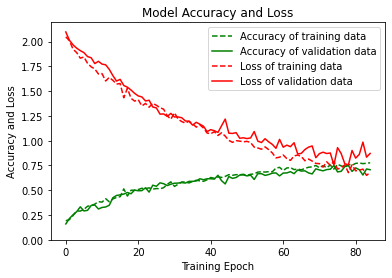

In [37]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [38]:
score = model.evaluate(test_generator, verbose=1)
print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

83/83 [==============================] - 66s 798ms/step - loss: 0.8865 - acc: 0.6870

Accuracy on test data: 0.69

Loss on test data: 0.89


In [39]:
y_pred_test = model.predict(test_generator)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = test_generator.classes
precision = precision_score(max_y_test, max_y_pred_test, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(max_y_test, max_y_pred_test, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(max_y_test, max_y_pred_test, average='weighted')
print('F1 score: %f' % f1)

83/83 [==============================] - 47s 560ms/step
Precision: 0.727478
Recall: 0.687025
F1 score: 0.684079


In [40]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

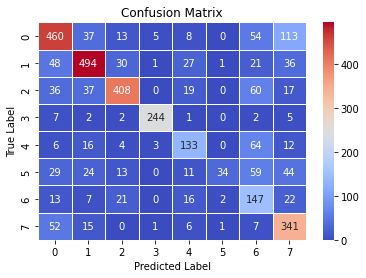


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       690
           1       0.78      0.75      0.77       658
           2       0.83      0.71      0.76       577
           3       0.96      0.93      0.94       263
           4       0.60      0.56      0.58       238
           5       0.89      0.16      0.27       214
           6       0.36      0.64      0.46       228
           7       0.58      0.81      0.67       423

    accuracy                           0.69      3291
   macro avg       0.71      0.65      0.64      3291
weighted avg       0.73      0.69      0.68      3291



In [41]:
show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))